In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib matplotlib
import cmcrameri.cm as cmc  # Importing the cmcrameri colormaps

In [2]:
%run figures.py 'little_dev_model/chem_model.h5' 

In [3]:
import xarray as xr

def sum_variables(xarray_obj, var_names, new_var_name):
    """
    Sums specified variables in an xarray object element-wise and adds the result as a new variable.
    
    Parameters:
    xarray_obj (xr.Dataset): The xarray Dataset containing the variables.
    var_names (list of str): A list of variable names to sum.
    new_var_name (str): The name of the new variable to store the sum.
    
    Returns:
    xr.Dataset: The modified xarray Dataset with the new summed variable.
    """
    # Check if all variable names exist in the xarray object
    missing_vars = [var for var in var_names if var not in xarray_obj.data_vars]
    if missing_vars:
        raise ValueError(f"The following variables are not in the xarray object: {missing_vars}")
    
    # Initialize a zero-filled DataArray based on the first variable's shape and coordinates
    sum_var = xr.zeros_like(xarray_obj[var_names[0]])
    
    # Sum the variables element-wise
    for var_name in var_names:
        sum_var += xarray_obj[var_name]
    
    # Add the summed variable to the xarray object
    xarray_obj[new_var_name] = sum_var
    
    return xarray_obj


In [6]:

primary_minerals = ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
secondary_minerals = ['Tremolite', 'Chrysotile', 'Talc', 'Quartz', 'Saponite_Mg', 'Saponite_FeMg', 'Illite_Mg', 
                      'Epidote', 'Zoisite', 'Chamosite-7A', 'Clinochlore-7A', 'Analcime', 
                      'Anhydrite', 'Calcite']

clays = ['Saponite_Mg', 'Illite_Mg', 'Chamosite-7A', 'Clinochlore-7A']
zeolites = ['Analcime']
amphiboles = ['Tremolite']
serpentinites = ['Chrysotile', 'Talc']
epidotes = ['Epidote', 'Zoisite']
olivine = ['Forsterite', 'Fayalite']
clinopyroxenes = ['Diopside', 'Hedenbergite']
plagioclases = ['Anorthite', 'Albite']
sulfates = ['Anhydrite']
carbonates = ['Calcite']

secondary_mineral_groups = {
    'clays': clays,
    'zeolites': zeolites,
    'amphiboles': amphiboles,
    'serpentinites': serpentinites,
    'epidotes': epidotes,
    'sulfates': sulfates,
    'carbonates': carbonates
}

primary_mineral_groups = {
    'olivine': olivine,
    'clinopyroxenes': clinopyroxenes,
    'plagioclases': plagioclases
}

for group, minerals in primary_mineral_groups.items():
    minerals = [string + "_VF" for string in minerals]
    data = sum_variables(data, minerals, group + "_VF")

for group, minerals in secondary_mineral_groups.items():
    minerals = [string + "_VF" for string in minerals]
    data = sum_variables(data, minerals, group + "_VF")


primary_minerals_VF = [string + "_VF" for string in primary_minerals]
secondary_minerals_VF = [string + "_VF" for string in secondary_minerals]

data = sum_variables(data, primary_minerals_VF, 'primary_minerals_VF')
data = sum_variables(data, secondary_minerals_VF, 'secondary_minerals_VF')
data['percentage_alteration'] = data['secondary_minerals_VF'] / data['primary_minerals_VF'].isel(time=0) * 100

primary_minerals_rate = [string + "_Rate" for string in primary_minerals]
secondary_minerals_rate = [string + "_Rate" for string in secondary_minerals]

data['percentage_alteration'] = data['secondary_minerals_VF'] / data['primary_minerals_VF'].isel(time=0) * 100

In [7]:
ds = data
positive_times = {}
# Iterate over each variable in the dataset
for var_name in primary_minerals_rate:
    # Check for positive values over the spatial domain (lat, lon) for each time
    positive_at_times = ds[var_name].where(ds[var_name] > 0).sum(dim=['x', 'y', 'z']) > 0
    
    # Extract the times when positive values exist
    times_with_positive = ds['time'].where(positive_at_times, drop=True)
    
    # Store the results in the dictionary
    positive_times[var_name] = times_with_positive.values

# Display the results
for var, times in positive_times.items():
    print(f"Variable '{var}' has positive values at times: {times}")

Variable 'Anorthite_Rate' has positive values at times: [  50.  100.  150.  200.  250.  300.  350.  400.  450.  500.  550.  600.
  650.  700.  750.  800.  850.  900.  950. 1000. 1050. 1100. 1150. 1200.
 1250. 1300. 1350. 1400. 1450. 1500. 1550. 1600. 1650. 1700. 1750. 1800.
 1850. 1900. 1950. 2000. 2050. 2100. 2150. 2200. 2250. 2300. 2350. 2400.
 2450. 2500. 2550. 2600. 2650. 2700. 2750. 2800. 2850. 2900. 2950. 3000.
 3050. 3100. 3150. 3200. 3250. 3300. 3350. 3400. 3450. 3500. 3550. 3600.
 3650. 3700. 3750. 3800. 3850. 3900. 3950. 4000. 4050. 4100. 4150. 4200.
 4250. 4300. 4350. 4400. 4450. 4500. 4550. 4600. 4650. 4700. 4750. 4800.
 4850. 4900. 4950. 5000. 5050. 5100. 5150. 5200. 5250. 5300. 5350. 5400.
 5450. 5500. 5550. 5600. 5650. 5700. 5750. 5800. 5850. 5900. 5950. 6000.
 6050. 6100. 6150. 6200. 6250. 6300. 6350. 6400. 6450. 6500. 6550. 6600.
 6650. 6700. 6750. 6800. 6850. 6900. 6950. 7000.]
Variable 'Albite_Rate' has positive values at times: [2150. 2200. 2250. 2300. 2350. 2400. 2

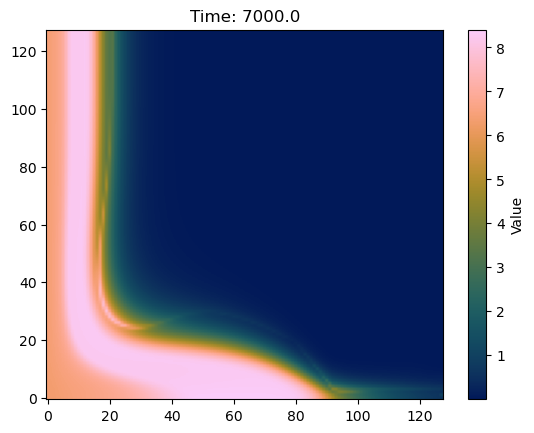

In [13]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cmcrameri.cm as cmc  # Importing the cmcrameri colormaps

# Load the dataset
# Replace 'path_to_your_dataset.nc' with the path to your actual NetCDF file
# ds = xr.open_dataset('path_to_your_dataset.nc')

ds = data
# Example: Assuming 'variable_name' is the name of the variable to plot and 'time' is the time dimension
variable_name = 'percentage_alteration'  # Replace with your actual variable name

# Select the variable data, assuming it has dimensions [time, x, z]
data_to_plot = ds[variable_name]

# Highlighted change: Determine vmin and vmax from the final time frame
final_frame = data_to_plot.isel(time=-1, y=0)  # Select the last time and y cell
vmin = final_frame.min().values
vmax = final_frame.max().values

# Initialize the plot
fig, ax = plt.subplots()
cmap = cmc.batlow  # Use a custom colormap from cmcrameri

# Set up the initial plot
# We start by plotting the first time step to initialize the plot
time_step = 0
initial_data = data_to_plot.isel(time=time_step, y=0)  # Select the first time and y cell
img = ax.imshow(initial_data, cmap=cmap, origin='lower', aspect='auto', vmin=vmin, vmax=vmax)  # Set vmin and vmax
cbar = plt.colorbar(img, ax=ax, orientation='vertical')
cbar.set_label('Value')
ax.set_title(f'Time: {data_to_plot.time.values[time_step]}')

# Define the update function for animation
def update(frame):
    ax.clear()
    data_at_time = data_to_plot.isel(time=frame, y=0)
    img = ax.imshow(data_at_time, cmap=cmap, origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    ax.set_title(f'Time: {data_to_plot.time.values[frame]}')
    return img,

# Create the animation
anim = FuncAnimation(fig, update, frames=len(data_to_plot.time), interval=200, blit=True)

# Save or display the animation
# To save the animation as a file, uncomment the next line
anim.save('animation.mp4', writer='ffmpeg')



In [ ]:
def extract_and_sum_spatial_domain(ds: xr.DataArray, x_bounds: tuple, y_bounds: tuple, z_bounds: tuple) -> xr.DataArray:
    """
    Extracts data over a specific spatial domain and sums it over the specified range for each time step.

    Parameters:
    ds (xr.DataArray): The input xarray DataArray object with coordinates x, y, z, and time.
    x_bounds (tuple): The bounds of the x coordinate as a tuple (x_min, x_max).
    y_bounds (tuple): The bounds of the y coordinate as a tuple (y_min, y_max).
    z_bounds (tuple): The bounds of the z coordinate as a tuple (z_min, z_max).

    Returns:
    xr.DataArray: A 1D DataArray containing the summed values over the spatial domain for each time step.
    """
    # Select the data within the specified spatial bounds
    selected_data = ds.sel(x=slice(*x_bounds), y=slice(*y_bounds), z=slice(*z_bounds))

    # Sum over the x, y, and z dimensions to get a 1D array over time
    summed_data = selected_data.sum(dim=['x', 'y', 'z'])

    return summed_data
